In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import shapefile
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
import folium
from folium.plugins import FastMarkerCluster
from functools import reduce
from statsmodels.api import families
from statsmodels.formula.api import ols
from scipy.stats import zscore
import math

# a nice way of filtering out deprecated warnings
import warnings
warnings.filterwarnings("ignore")
os.chdir("../raw_data/")

In [3]:
# Format covid data 
covid_data = pd.read_csv("../raw_data/statistic_id1109711_number-of-new-covid-19-cases-in-nyc-from-mar-8-2020-to-july-31-2021-by-day.csv")
covid_data = covid_data.rename(columns = ({"Number of new COVID-19 cases in NYC from Mar. 8, 2020 to July 31, 2021, by day": "Date",
                             "Unnamed: 1": "Cases"}))
covid_data = covid_data.drop([0,1])
covid_data["Date"] = pd.to_datetime(covid_data["Date"], format = "%m/%d/%y")
covid_data = covid_data.loc[pd.DatetimeIndex(covid_data["Date"]).year <2021]

In [4]:
covid_data

,Date,Cases
2,2020-03-08,21.0
3,2020-03-09,57.0
4,2020-03-10,69.0
5,2020-03-11,155.0
6,2020-03-12,355.0
...,...,...
296,2020-12-27,2886.0
297,2020-12-28,5386.0
298,2020-12-29,5200.0
299,2020-12-30,4975.0


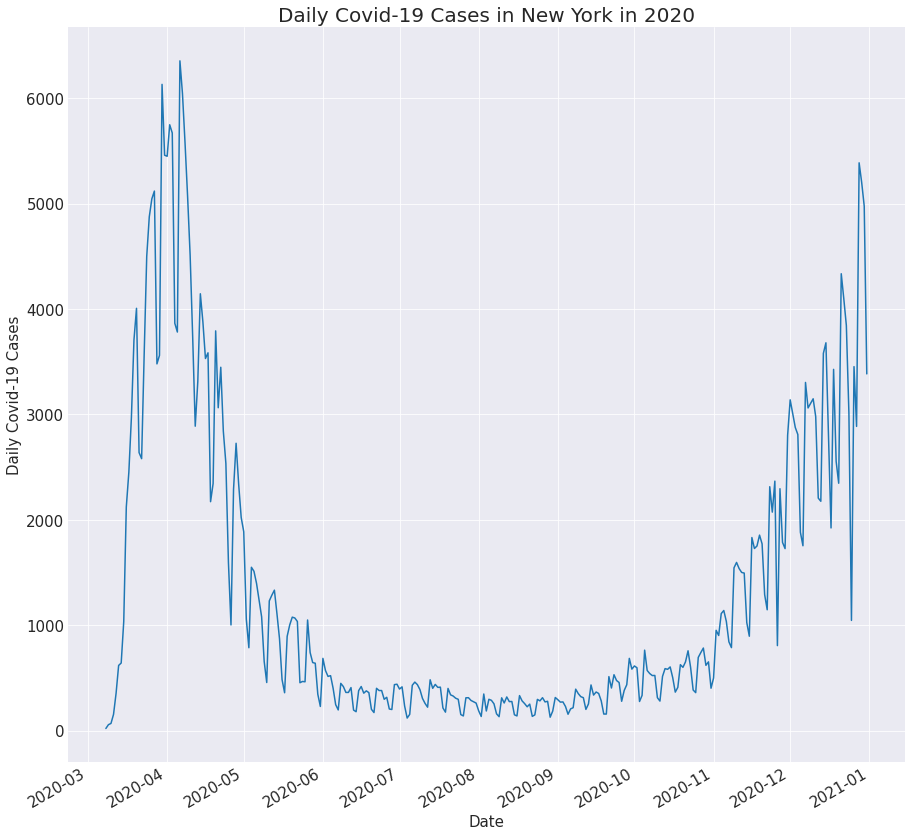

In [5]:
# Change the style of plot
plt.style.use('seaborn-darkgrid')
 
# Create a color palette
palette = plt.get_cmap('Set1')
num=0

fig, ax = plt.subplots(figsize = (15,15))
ax.set_xlabel("Date", size = 15)
ax.set_ylabel("Daily Covid-19 Cases", size = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
ax.plot(covid_data['Date'], covid_data["Cases"])
# Align the tick labels so they look better.
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%m-%d')
ax.set_title('Daily Covid-19 Cases in New York in 2020', size = 20)

fig.savefig('../plots/Daily_Covid_Cases.png', dpi = 400)


In [6]:
march_rides = pd.read_csv("../preprocessed_data/march_rides_per_day.csv")
april_rides = pd.read_csv("../preprocessed_data/april_rides_per_day.csv")
may_rides = pd.read_csv("../preprocessed_data/may_rides_per_day.csv")
june_rides = pd.read_csv("../preprocessed_data/june_rides_per_day.csv")
july_rides = pd.read_csv("../preprocessed_data/july_rides_per_day.csv")
august_rides = pd.read_csv("../preprocessed_data/august_rides_per_day.csv")
september_rides = pd.read_csv("../preprocessed_data/september_rides_per_day.csv")
october_rides = pd.read_csv("../preprocessed_data/october_rides_per_day.csv")
november_rides = pd.read_csv("../preprocessed_data/november_rides_per_day.csv")
december_rides = pd.read_csv("../preprocessed_data/december_rides_per_day.csv")


In [7]:
all_months_rides = pd.concat([march_rides, april_rides, may_rides, june_rides, july_rides, august_rides, september_rides,
                             october_rides, november_rides, december_rides])

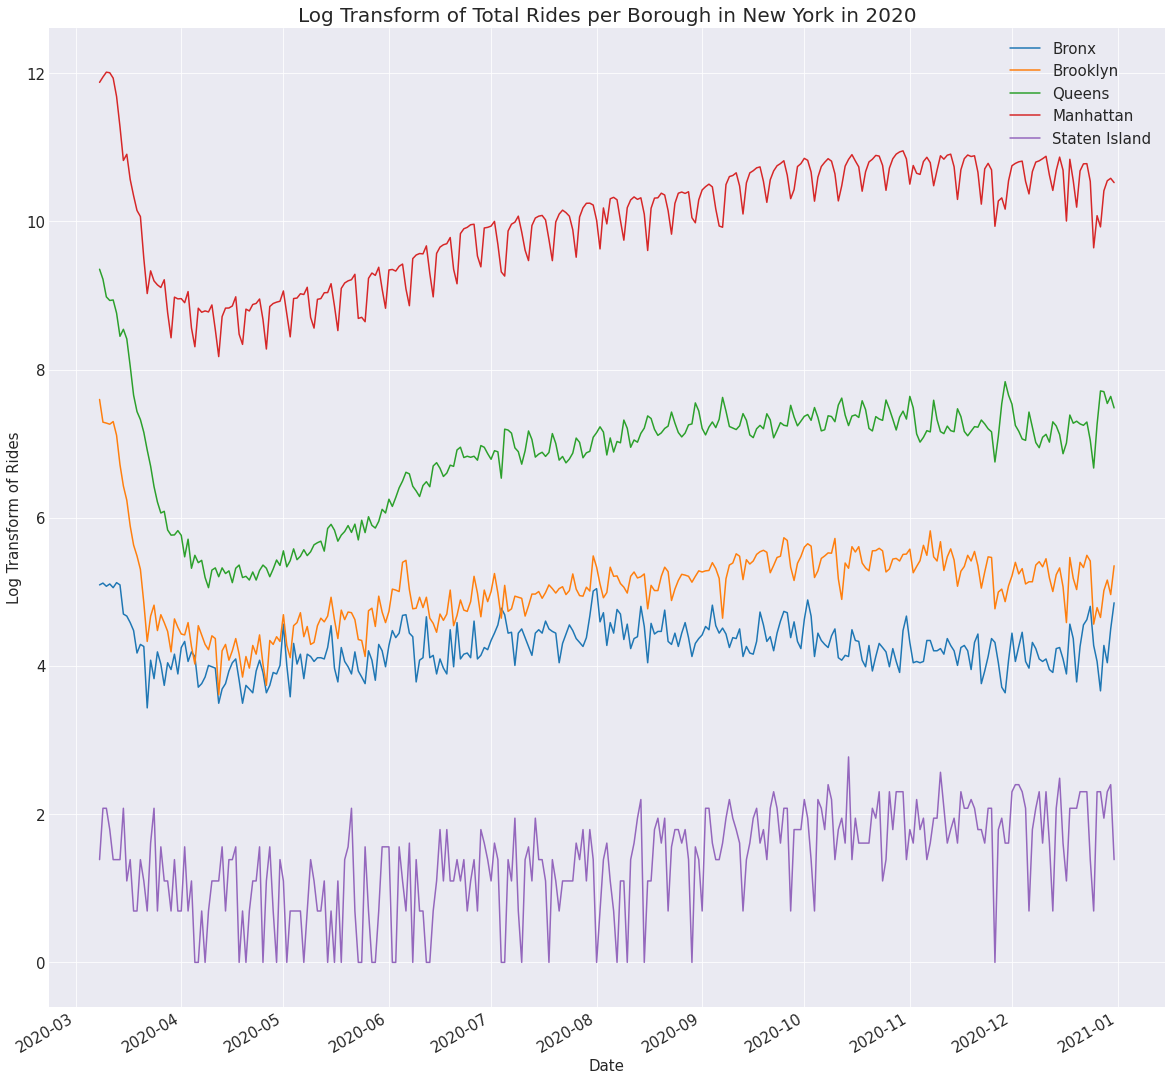

In [8]:
bronx_rides_csv = all_months_rides.loc[all_months_rides["borough"] == "Bronx"]
brooklyn_rides_csv = all_months_rides.loc[all_months_rides["borough"] == "Brooklyn"]
queens_rides_csv = all_months_rides.loc[all_months_rides["borough"] == "Queens"]
manhattan_rides_csv = all_months_rides.loc[all_months_rides["borough"] == "Manhattan"]
statenisland_rides_csv = all_months_rides.loc[all_months_rides["borough"] == "Staten Island"]

boroughs_rides_count = ["Bronx_Rides", "Brooklyn_Rides", "Queens_Rides", "Manhattan_Rides", "StatenIsland_Rides"]

# Rename columns
borough_rides_list = [bronx_rides_csv, brooklyn_rides_csv, queens_rides_csv, manhattan_rides_csv , statenisland_rides_csv]
for i in range(len(borough_rides_list)):
    borough_rides_list[i].rename(columns = {"count": boroughs_rides_count[i]}, inplace = True)

    
# Code adapted from user: Zero from 
# https://stackoverflow.com/questions/52223045/merge-multiple-dataframes-based-on-a-common-column


joined_df = reduce(lambda x,y: pd.merge(x,y, on='pickup_day', how='outer'),
                   [bronx_rides_csv,brooklyn_rides_csv, queens_rides_csv,
                    manhattan_rides_csv , statenisland_rides_csv]).fillna(statenisland_rides_csv["StatenIsland_Rides"].mean())
joined_df = joined_df.drop(joined_df.columns[[0,2,4,5,7,8,10,11,13,14]], axis = 1)
joined_df["pickup_day"] = pd.to_datetime(joined_df["pickup_day"])

# Plot the visualisation of the total rides per borough
# Change the style of plot
plt.style.use('seaborn-darkgrid')

# Create a color palette
palette = plt.get_cmap('Set1')
num=0

fig, ax = plt.subplots(figsize = (20,20))
ax.set_xlabel("Date", size = 15)
ax.set_ylabel("Log Transform of Rides", size = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
l1 = ax.plot(joined_df['pickup_day'], np.log(joined_df["Bronx_Rides"]), label = "Bronx")
l2 = ax.plot(joined_df['pickup_day'], np.log(joined_df["Brooklyn_Rides"]), label = "Brooklyn")
l3 = ax.plot(joined_df['pickup_day'], np.log(joined_df["Queens_Rides"]), label = "Queens")
l4 = ax.plot(joined_df['pickup_day'], np.log(joined_df["Manhattan_Rides"]), label = "Manhattan")
l5 =ax.plot(joined_df['pickup_day'], np.log(joined_df["StatenIsland_Rides"]), label = "Staten Island")

# Align tick labels so they look better.
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%m-%d')
ax.set_title("Log Transform of Total Rides per Borough in New York in 2020", size = 20)

plt.legend(prop = {'size': 15})
fig.savefig('../plots/Log_Total_Rides_per_Borough.png', dpi = 400)

In [9]:
march_distance = pd.read_csv("../preprocessed_data/march_distance.csv")
april_distance = pd.read_csv("../preprocessed_data/april_distance.csv")
may_distance = pd.read_csv("../preprocessed_data/may_distance.csv")
june_distance = pd.read_csv("../preprocessed_data/june_distance.csv")
july_distance = pd.read_csv("../preprocessed_data/july_distance.csv")
august_distance = pd.read_csv("../preprocessed_data/august_distance.csv")
september_distance = pd.read_csv("../preprocessed_data/september_distance.csv")
october_distance = pd.read_csv("../preprocessed_data/october_distance.csv")
november_distance = pd.read_csv("../preprocessed_data/november_distance.csv")
december_distance = pd.read_csv("../preprocessed_data/december_distance.csv")

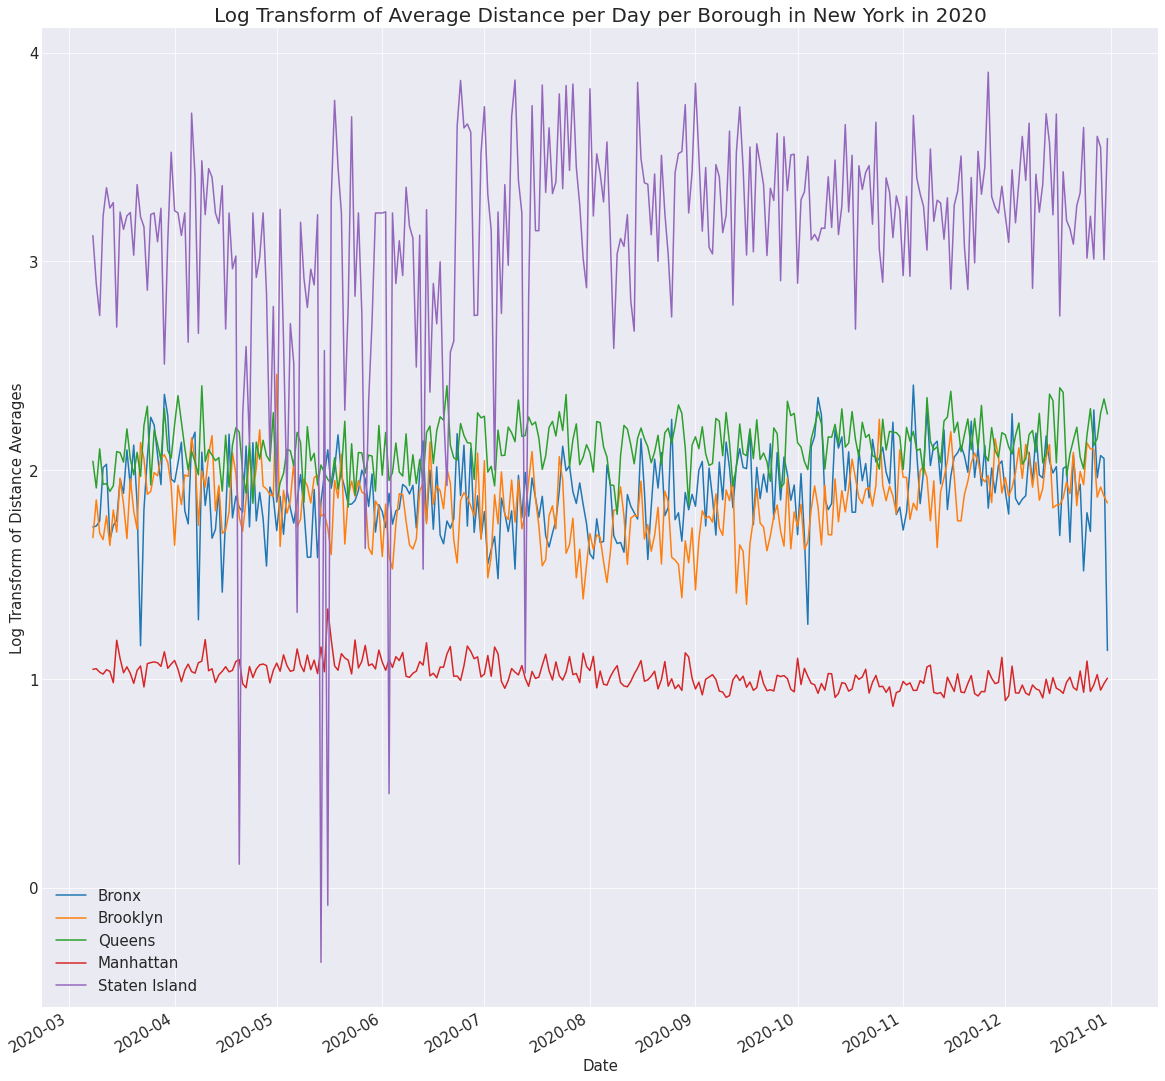

In [10]:
all_months_distance = pd.concat([march_distance, april_distance, may_distance, june_distance, july_distance, august_distance, september_distance,
                             october_distance, november_distance, december_distance])

bronx_distance_csv = all_months_distance.loc[all_months_distance["borough"] == "Bronx"]
brooklyn_distance_csv = all_months_distance.loc[all_months_distance["borough"] == "Brooklyn"]
queens_distance_csv = all_months_distance.loc[all_months_distance["borough"] == "Queens"]
manhattan_distance_csv = all_months_distance.loc[all_months_distance["borough"] == "Manhattan"]
statenisland_distance_csv = all_months_distance.loc[all_months_distance["borough"] == "Staten Island"]

boroughs_distance_count = ["Bronx_Distance", "Brooklyn_Distance", "Queens_Distance", "Manhattan_Distance", "StatenIsland_Distance"]
borough_distance_list = [bronx_distance_csv, brooklyn_distance_csv, queens_distance_csv,
                         manhattan_distance_csv , statenisland_distance_csv]
# Rename columns
for i in range(len(borough_distance_list)):
    borough_distance_list[i].rename(columns = {"trip_distance": boroughs_distance_count[i]}, inplace = True)
    
distance_joined_df = reduce(lambda x,y: pd.merge(x,y, on='pickup_day', how='outer'), 
                            [bronx_distance_csv,brooklyn_distance_csv,
                              queens_distance_csv,
                              manhattan_distance_csv ,
                              statenisland_distance_csv]).fillna(statenisland_distance_csv["StatenIsland_Distance"].mean())
distance_joined_df = distance_joined_df.drop(distance_joined_df.columns[[0,2,4,5,7,8,10,11,13,14]], axis = 1)
distance_joined_df["pickup_day"] = pd.to_datetime(distance_joined_df["pickup_day"])

# Plot log transform of average distance per day visualisation 
# Change the style of plot
plt.style.use('seaborn-darkgrid')

# Create a color palette
palette = plt.get_cmap('Set1')
num=0

fig, ax = plt.subplots(figsize = (20,20))
ax.set_xlabel("Date", size = 15)
ax.set_ylabel("Log Transform of Distance Averages", size = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# l1 = ax.plot(distance_joined_df['pickup_day'], distance_joined_df["Bronx_Distance"], label = "Bronx")
# l2 = ax.plot(distance_joined_df['pickup_day'], distance_joined_df["Brooklyn_Distance"], label = "Brooklyn")
# l3 = ax.plot(distance_joined_df['pickup_day'], distance_joined_df["Queens_Distance"], label = "Queens")
# l4 = ax.plot(distance_joined_df['pickup_day'], distance_joined_df["Manhattan_Distance"], label = "Manhattan")
# l5 =ax.plot(distance_joined_df['pickup_day'], distance_joined_df["StatenIsland_Distance"], label = "Staten Island")
l1 = ax.plot(distance_joined_df['pickup_day'], np.log(distance_joined_df["Bronx_Distance"]), label = "Bronx")
l2 = ax.plot(distance_joined_df['pickup_day'], np.log(distance_joined_df["Brooklyn_Distance"]), label = "Brooklyn")
l3 = ax.plot(distance_joined_df['pickup_day'], np.log(distance_joined_df["Queens_Distance"]), label = "Queens")
l4 = ax.plot(distance_joined_df['pickup_day'], np.log(distance_joined_df["Manhattan_Distance"]), label = "Manhattan")
l5 =ax.plot(distance_joined_df['pickup_day'], np.log(distance_joined_df["StatenIsland_Distance"]), label = "Staten Island")

# Align tick labels so they look better.
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%m-%d')
ax.set_title("Log Transform of Average Distance per Day per Borough in New York in 2020", size = 20)

plt.legend(prop = {'size': 15})
fig.savefig('../plots/Log_Average_Daily_Distance_per_Borough.png', dpi = 400)

In [11]:

march_passengers = pd.read_csv("../preprocessed_data/march_passengers.csv")
april_passengers = pd.read_csv("../preprocessed_data/april_passengers.csv")
may_passengers = pd.read_csv("../preprocessed_data/may_passengers.csv")
june_passengers = pd.read_csv("../preprocessed_data/june_passengers.csv")
july_passengers = pd.read_csv("../preprocessed_data/july_passengers.csv")
august_passengers = pd.read_csv("../preprocessed_data/august_passengers.csv")
september_passengers = pd.read_csv("../preprocessed_data/september_passengers.csv")
october_passengers = pd.read_csv("../preprocessed_data/october_passengers.csv")
november_passengers = pd.read_csv("../preprocessed_data/november_passengers.csv")
december_passengers = pd.read_csv("../preprocessed_data/december_passengers.csv")

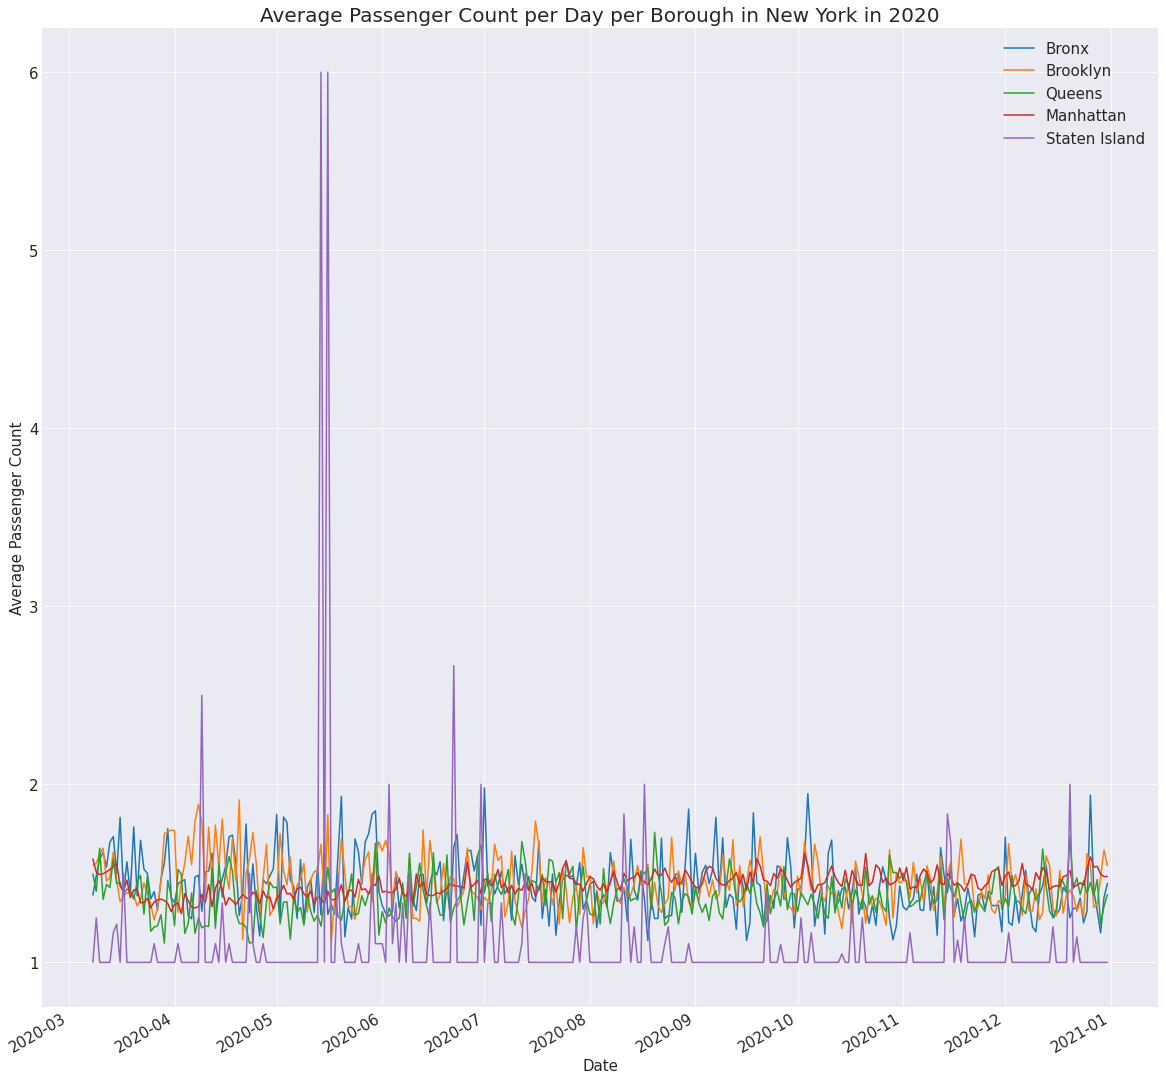

In [12]:
all_months_passengers = pd.concat([march_passengers, april_passengers, may_passengers, june_passengers,
                                   july_passengers, august_passengers, september_passengers,
                             october_passengers, november_passengers, december_passengers])

bronx_passengers_csv = all_months_passengers.loc[all_months_passengers["borough"] == "Bronx"]
brooklyn_passengers_csv = all_months_passengers.loc[all_months_passengers["borough"] == "Brooklyn"]
queens_passengers_csv = all_months_passengers.loc[all_months_passengers["borough"] == "Queens"]
manhattan_passengers_csv = all_months_passengers.loc[all_months_passengers["borough"] == "Manhattan"]
statenisland_passengers_csv = all_months_passengers.loc[all_months_passengers["borough"] == "Staten Island"]

boroughs_passengers_count = ["Bronx_Passengers", "Brooklyn_Passengers", "Queens_Passengers",
                             "Manhattan_Passengers", "StatenIsland_Passengers"]
borough_passengers_list = [bronx_passengers_csv, brooklyn_passengers_csv, queens_passengers_csv,
                         manhattan_passengers_csv , statenisland_passengers_csv]
# Rename columns
for i in range(len(borough_passengers_list)):
    borough_passengers_list[i].rename(columns = {"passenger_count": boroughs_passengers_count[i]}, inplace = True)
    
passengers_joined_df = reduce(lambda x,y: pd.merge(x,y, on='pickup_day', how='outer'),
                              [bronx_passengers_csv,
                              brooklyn_passengers_csv,
                              queens_passengers_csv,
                              manhattan_passengers_csv ,
                              statenisland_passengers_csv]).fillna(statenisland_passengers_csv["StatenIsland_Passengers"].mean())
passengers_joined_df = passengers_joined_df.drop(passengers_joined_df.columns[[0,2,4,5,7,8,10,11,13,14]], axis = 1)
passengers_joined_df["pickup_day"] = pd.to_datetime(passengers_joined_df["pickup_day"])

# Plot log transform of average distance per day visualisation 
# Change the style of plot
plt.style.use('seaborn-darkgrid')

# Create a color palette
palette = plt.get_cmap('Set1')
num=0

fig, ax = plt.subplots(figsize = (20,20))
ax.set_xlabel("Date", size = 15)
ax.set_ylabel("Average Passenger Count", size = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
# l1 = ax.plot(distance_joined_df['pickup_day'], distance_joined_df["Bronx_Distance"], label = "Bronx")
# l2 = ax.plot(distance_joined_df['pickup_day'], distance_joined_df["Brooklyn_Distance"], label = "Brooklyn")
# l3 = ax.plot(distance_joined_df['pickup_day'], distance_joined_df["Queens_Distance"], label = "Queens")
# l4 = ax.plot(distance_joined_df['pickup_day'], distance_joined_df["Manhattan_Distance"], label = "Manhattan")
# l5 =ax.plot(distance_joined_df['pickup_day'], distance_joined_df["StatenIsland_Distance"], label = "Staten Island")
l1 = ax.plot(passengers_joined_df['pickup_day'], passengers_joined_df["Bronx_Passengers"], label = "Bronx")
l2 = ax.plot(passengers_joined_df['pickup_day'], passengers_joined_df["Brooklyn_Passengers"], label = "Brooklyn")
l3 = ax.plot(passengers_joined_df['pickup_day'], passengers_joined_df["Queens_Passengers"], label = "Queens")
l4 = ax.plot(passengers_joined_df['pickup_day'], passengers_joined_df["Manhattan_Passengers"], label = "Manhattan")
l5 =ax.plot(passengers_joined_df['pickup_day'], passengers_joined_df["StatenIsland_Passengers"], label = "Staten Island")

# Align tick labels so they look better.
fig.autofmt_xdate()
ax.fmt_xdata = mdates.DateFormatter('%m-%d')
ax.set_title("Average Passenger Count per Day per Borough in New York in 2020", size = 20)

plt.legend(prop = {'size': 15})
fig.savefig('../plots/Average_Daily_Passenger_Count.png', dpi = 400)

In [13]:
covid_data

,Date,Cases
2,2020-03-08,21.0
3,2020-03-09,57.0
4,2020-03-10,69.0
5,2020-03-11,155.0
6,2020-03-12,355.0
...,...,...
296,2020-12-27,2886.0
297,2020-12-28,5386.0
298,2020-12-29,5200.0
299,2020-12-30,4975.0


In [14]:
joined_df = joined_df.rename(columns = {"pickup_day" : "Date"})

In [24]:
# 
covid_joined = reduce(lambda x,y: pd.merge(x,y, on='Date', how='outer'), [covid_data, joined_df])

In [25]:

borough_rides_list = [bronx_rides_csv, brooklyn_rides_csv, queens_rides_csv, manhattan_rides_csv , statenisland_rides_csv]
borough_distance_list = [bronx_distance_csv, brooklyn_distance_csv, queens_distance_csv, manhattan_distance_csv , statenisland_distance_csv]

boroughs_covid_count = ["Bronx_Count", "Brooklyn_Count", "Queens_Count", "Manhattan_Count", "StatenIsland_Count"]



bronx_df = pd.DataFrame(data = {"Covid": covid_joined["Cases"].tolist(), 
                                 "Rides": joined_df["Bronx_Rides"].tolist(),
                                 "Distance": distance_joined_df["Bronx_Distance"].tolist(),
                                 "Passengers": passengers_joined_df["Bronx_Passengers"].tolist()})
brooklyn_df = pd.DataFrame(data = {"Covid": covid_joined["Cases"].tolist(), 
                                    "Rides": joined_df["Brooklyn_Rides"].tolist(),
                                 "Distance": distance_joined_df["Brooklyn_Distance"].tolist(),
                                    "Passengers": passengers_joined_df["Brooklyn_Passengers"].tolist()})
queens_df = pd.DataFrame(data = {"Covid": covid_joined["Cases"].tolist(), 
                                    "Rides": joined_df["Queens_Rides"].tolist(),
                                 "Distance": distance_joined_df["Queens_Distance"].tolist(),
                                    "Passengers": passengers_joined_df["Queens_Passengers"]})
manhattan_df = pd.DataFrame(data = {"Covid": covid_joined["Cases"].tolist(), 
                                    "Rides": joined_df["Manhattan_Rides"].tolist(),
                                 "Distance": distance_joined_df["Manhattan_Distance"].tolist(),
                                    "Passengers": passengers_joined_df["Manhattan_Passengers"].tolist()})
statenisland_df = pd.DataFrame(data = {"Covid": covid_joined["Cases"].tolist(), 
                                    "Rides": joined_df["StatenIsland_Rides"].tolist(),
                                 "Distance": distance_joined_df["StatenIsland_Distance"].tolist(),
                                    "Passengers": passengers_joined_df["StatenIsland_Passengers"].tolist()})

In [26]:
# Standardise dataframes
bronx_df_std = bronx_df.astype(float).apply(zscore)
brooklyn_df_std = brooklyn_df.astype(float).apply(zscore)
queens_df_std = queens_df.astype(float).apply(zscore)
manhattan_df_std = manhattan_df.astype(float).apply(zscore)
statenisland_df_std = statenisland_df.astype(float).apply(zscore)

In [27]:
bronx_df_std.to_csv("../preprocessed_data/bronx_fitting.csv")
brooklyn_df_std.to_csv("../preprocessed_data/brooklyn_fitting.csv")
queens_df_std.to_csv("../preprocessed_data/queens_fitting.csv")
manhattan_df_std.to_csv("../preprocessed_data/manhattan_fitting.csv")
statenisland_df_std.to_csv("../preprocessed_data/statenisland_fitting.csv")

In [28]:
pd.options.display.float_format = '{:,.4f}'.format

In [29]:
brooklyn_df_std.describe().loc[['mean','std']]

,Covid,Rides,Distance,Passengers
mean,-0.0000,-0.0000,-0.0000,0.0000
std,1.0017,1.0017,1.0017,1.0017


In [30]:
passengers_joined_df.describe()

,Bronx_Passengers,Brooklyn_Passengers,Queens_Passengers,Manhattan_Passengers,StatenIsland_Passengers
count,299.0000,299.0000,299.0000,299.0000,299.0000
mean,1.4254,1.4440,1.3709,1.4385,1.1050
std,0.1704,0.1465,0.1176,0.0622,0.4533
min,1.1228,1.1157,1.1075,1.2739,1.0000
25%,1.2994,1.3353,1.2809,1.4002,1.0000
50%,1.4000,1.4200,1.3687,1.4371,1.0000
75%,1.5172,1.5418,1.4472,1.4784,1.0000
max,1.9797,1.9121,1.7308,1.6133,6.0000
